In [283]:
import transformers
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

from sklearn.metrics.pairwise import cosine_similarity

## SloBERTa Score

Here we define a function to compute the [BERT score](https://arxiv.org/abs/1904.09675) for Slovene text using the [SloBERTa](https://huggingface.co/EMBEDDIA/sloberta) model. The `bert_score` library does support the Slovene language through a multilingual BERT model. However, we decided to use the SloBERTa model sinci it was specifically fine-tuned for Slovene. To do this, we implemented a custom `SloBERTaScorer` class.

In [65]:
class SloBERTaScorer:

    def __init__(self, model_name='EMBEDDIA/sloberta'):
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
        self.model = transformers.AutoModelForMaskedLM.from_pretrained(model_name)
        self.model.eval()


    @torch.no_grad()
    def get_embeddings(self, text: str, normalize=True):
        encoded = self.tokenizer(text, return_tensors='pt', truncation=True)
        outputs = self.model(**encoded, output_hidden_states=True)
        embeddings = torch.stack(outputs['hidden_states']).squeeze().mean(dim=0)
        attention_mask = encoded['attention_mask'].squeeze(0).bool()
        embeddings = embeddings[attention_mask][1:-1] # Exclude [CLS] and [SEP] tokens
        if normalize:
            embeddings = torch.nn.functional.normalize(embeddings, dim=1)
        return embeddings.cpu().numpy()
    

    def score(self, candidate: str, reference: str):
        candidate_emb = self.get_embeddings(candidate)
        reference_emb = self.get_embeddings(reference)
        if candidate_emb.shape[0] == 0 or reference_emb.shape[0] == 0:
            return 0.0, 0.0, 0.0

        sims = cosine_similarity(candidate_emb, reference_emb)
        precision = sims.max(axis=1).mean()
        recall = sims.max(axis=0).mean()
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        return precision, recall, f1

## Parsing Generated Reports 

In [52]:
def get_all_indices(txt: str, sub: str):
    start = 0
    indices = []
    while True:
        start = txt.find(sub, start)
        if start == -1:
            break
        indices.append(start)
        start += len(sub)  # Move past the last found index
    return np.array(indices)


def read_results(path: str):
    with open(path, 'r') as f:
        txt = f.read()
    
    idx_in = get_all_indices(txt, 'INPUT')
    idx_gt = get_all_indices(txt, 'GROUND-TRUTH')
    idx_out = get_all_indices(txt, 'MODEL-OUTPUT')
    sep = '=' * 40

    results = []
    for i_in, i_gt, i_out  in zip(idx_in, idx_gt, idx_out):
        i_end = txt.find(sep, i_out)

        input_text = txt[(txt.find(':', i_in) + 1):i_gt].strip()
        gt_text = txt[(txt.find(':', i_gt) + 1):i_out].strip()
        out_text = txt[(txt.find(':', i_out) + 1):i_end].strip()

        results.append({
            'input': input_text,
            'ground_truth': gt_text,
            'model_output': out_text
        })

    return results

## Evaluation Results

Here, we compute the evaluation results for 500 reports, generated by each of the 4 methods. We use the `SloBERTaScorer` to obtain the *precision*, *recall*, and *F1* scores for each report.

In [ ]:
scorer = SloBERTaScorer()

results_dir = '../evaluation/results/'
result_names = [
    'instructions_gams9b_eval.txt',
    'finetuned_gams9b_eval.txt',
    'finetuned_instructed_gams9b_eval.txt',
    'rag_gams9b_eval.txt'
]

name_to_method_map = {
    'instructions_gams9b_eval.txt': 'Instructed',
    'finetuned_gams9b_eval.txt': 'Fine-tuned',
    'finetuned_instructed_gams9b_eval.txt': 'Fine-tuned + Instructed',
    'rag_gams9b_eval.txt': 'Fine-Tuned + Instructed + RAG'
}

evaluation_results_list = []

for name in result_names:
    print(f'Evaluating {name}')
    path = os.path.join(results_dir, name)
    results = read_results(path)

    for i, entry in enumerate(results):
        print(f'Processing entry {i+1} of {len(results)}', end='\r')
        
        out = entry['model_output']
        gt = entry['ground_truth']
        p, r, f1 = scorer.score(out, gt)
        evaluation_results_list.append({
            'name': name,
            'input': entry['input'],
            'ground_truth': gt,
            'model_output': out,
            'precision': p,
            'recall': r,
            'f1': f1
        })

    evaluation_results = pd.DataFrame(evaluation_results_list)

evaluation_results = pd.DataFrame(evaluation_results_list)
evaluation_results['method'] = evaluation_results['name'].map(name_to_method_map)

# Also compute report lengths and relative differences
evaluation_results['ground_truth_length'] = evaluation_results['ground_truth'].str.split().str.len()
evaluation_results['model_output_length'] = evaluation_results['model_output'].str.split().str.len()
evaluation_results['len_diff_rel'] = evaluation_results['model_output_length'] / evaluation_results['ground_truth_length']

We also estimate the uncertainty of the scores as the standard error.

In [248]:
grp = evaluation_results.groupby('method')[['precision', 'recall', 'f1', 'len_diff_rel']]
eval_mean = grp.mean()
eval_stderr = grp.std() / np.sqrt(grp.size().values[:, np.newaxis])

method_names = list(name_to_method_map.values())
eval_summary = eval_mean.round(3).astype(str) + ' ± ' + eval_stderr.round(3).astype(str)
eval_summary = eval_summary.reindex(method_names)
eval_summary

,precision,recall,f1,len_diff_rel
method,,,,
Base Instructed,0.608 ± 0.004,0.683 ± 0.004,0.643 ± 0.004,1.904 ± 0.042
Fine-tuned,0.774 ± 0.003,0.753 ± 0.004,0.762 ± 0.003,0.818 ± 0.022
Fine-tuned and Instructed,0.817 ± 0.003,0.752 ± 0.004,0.781 ± 0.003,0.732 ± 0.017
RAG,0.815 ± 0.003,0.752 ± 0.004,0.779 ± 0.003,0.752 ± 0.018


Here, the distributions of the F1 scores for each method are shown. Most notably, we can observe that the scores of the *Base Instructed* model are much more inconsistent than for the other methods.

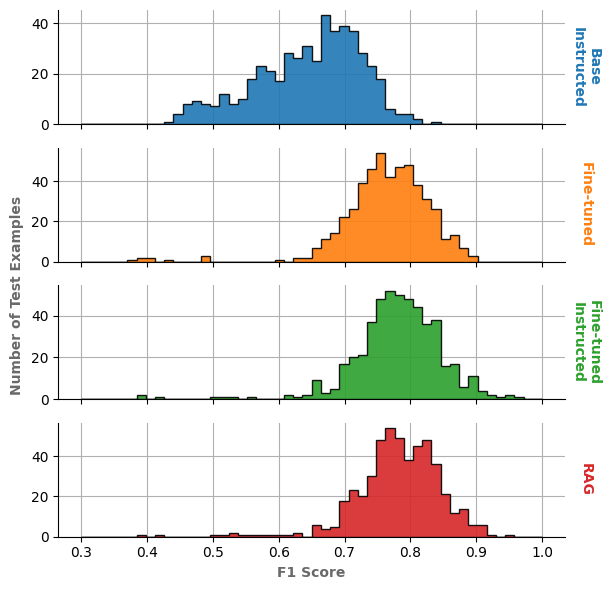

In [224]:
fig, axs = plt.subplots(4, 1, figsize=(6, 6), sharex=True)
colors = plt.colormaps['tab10'].colors

for ax, method, color in zip(axs, method_names, colors):

    eval_method = evaluation_results[evaluation_results['method'] == method]
    ax.hist(eval_method['f1'], bins=50, alpha=0.9, color=color, edgecolor='black', zorder=10, histtype='stepfilled', range=(0.3, 1.0))

    label = method.replace(' and ', '\n')
    label = 'Base\nInstructed' if label == 'Base Instructed' else label
    ax.spines[['top', 'right']].set_visible(False)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(label, fontweight='bold', color=color, rotation=-90, labelpad=15, va='center')

    ax.grid(zorder=0)

fig.text(-0.01, 0.5, 'Number of Test Examples', va='center', rotation='vertical', color='dimgray',  fontweight='bold')

axs[-1].set_xlabel('F1 Score', fontweight='bold', color='dimgray')
fig.tight_layout()

## Examples of Generated Reports

In [398]:
method = 'Fine-tuned and Instructed'
k = 3
show_input = False

eval_method = evaluation_results[evaluation_results['method'] == method]
f1 = eval_method.f1.values

indices_sorted = np.argsort(f1)
indices_bad = np.flatnonzero((f1 == 0) | (eval_method.model_output_length < 5).values)
indices_sorted = np.array([i for i in indices_sorted if i not in indices_bad])

indices_cand_worst = indices_sorted[:k]
indices_cand_best = indices_sorted[-k:][::-1]

def print_examples(label: str, indices: np.ndarray):
    print(f'{label} {k} examples for {method}:\n')
    print('====================================================')

    for i in indices:
        print(f'Example {i} (F1 = {f1[i]:.3f}):')
        if show_input:
            print(f'\nInput:\n-------------')
            print(eval_method.input.values[i])

        print('\nGround-Truth:\n-------------')
        print(eval_method.ground_truth.values[i])

        print(f'\nModel Output:\n------------------')
        print(eval_method.model_output.values[i])
        print('\n' + '=' * 52)

print_examples('Best', indices_cand_best)

Best 3 examples for Fine-tuned and Instructed:

Example 83 (F1 = 0.966):

Ground-Truth:
-------------
Podatki o prometu.
Na štajerski avtocesti je zaradi nesreče zaprt vozni pas med priključkoma Celje-zahod in Celje-center proti Mariboru.

Model Output:
------------------
Podatki o prometu.
Na štajerski avtocesti proti Mariboru je zaradi prometne nesreče zaprt vozni pas med priključkoma Celje-zahod in Celje-center.

Example 39 (F1 = 0.954):

Ground-Truth:
-------------
Podatki o prometu.
Zaradi prometne nesreče sta ljubljanski južni obvoznici na razcepu Kozarje zaprta vozni in prehitevalni pas iz smeri Viča proti Brezovici.
Cesta Vrhnika-Horjul-Šentjošt nad Horjulom je zaradi zemeljskega plazu zaprta pri Vrzdêncu. Obvoz je prek Polhovega Gradca.

Model Output:
------------------
Podatki o prometu.
Na južni ljubljanski obvoznici sta zaradi prometne nesreče na razcepu Kozarje zaprta vozni in prehitevalni pas iz smeri Viča proti Brezovici.
Cesta Vrhnika-Horjul-Šentjošt nad Horjulom je zar

In [399]:
print_examples('Worst', indices_cand_worst)

Worst 3 examples for Fine-tuned and Instructed:

Example 496 (F1 = 0.619):

Ground-Truth:
-------------
Podatki o prometu.
V Kranju na Cesti Staneta Žagarja in naprej na cesti Polica-Naklo-Podtabor-Radovljica-Lesce je spolzko vozišče zaradi razlite nafte. Vozite previdno.
Cesta Cerkvenjak-Vitomarci je zaradi poplavljenega vozišča zaprta pri Vitomarcih.
Ta konec tedna potekajo številne prireditve, zapor cest bo več. Danes bo med drugim zaradi tekaške prireditve zaprta Cesta Tekačevo - Rogaška Slatina - Rajnkovec, in sicer za eno uro od 9-ih in 50 minut naprej.
Zaradi kolesarske prireditve bodo kratkotrajne 30-minutne popolne zapore cest na relaciji Vrhnika - Logatec - Kaṷce - Godovíč - Črni Vrh - Coṷ - Ajdovščina - Selo - Nova Gorica - Dobrovo, in sicer tja do 13-ih in 45 minut.
Cesta Kranjska Gora - Vršič pa bo prav tako zaradi prireditve zaprta od 14-ih 30 do 18-ih in 30 minut.

Model Output:
------------------
Podatki o prometu.
Na štajerski avtocesti proti Mariboru je zaradi pokvarj

## Manual Evaluation

Here, we also include the results from manual evaluation on a smaller subset, which was performed using a dedicated Streamlit app in the `src/evaluation/app` directory. It is included here for the sake of completeness and to estimate the uncertainty of the obtained manual evaluation scores.

In [433]:
man_eval_dir = '../evaluation/results/'
man_eval_csvs = [f for f in os.listdir(man_eval_dir) if f.endswith('.csv')]

evaluation_results_manual = []
for fname in man_eval_csvs:
    path = os.path.join(man_eval_dir, fname)
    res_cur = pd.read_csv(path)
    evaluation_results_manual.append(res_cur)

evaluation_results_manual = pd.concat(evaluation_results_manual, ignore_index=True)
scenario_mapping = { k[:-len('.txt')]: v for k, v in name_to_method_map.items() }
evaluation_results_manual['scenario'] = evaluation_results_manual['scenario'].map(scenario_mapping)
evaluation_results_manual['better'] *= 100  # Convert to percentage

cols = ['rating', 'better']
grp = evaluation_results_manual.groupby('scenario')[cols]
eval_man_mean = grp.mean().round(2).astype(str)
eval_man_stderr = (grp.std() / np.sqrt(grp.size().values[:, np.newaxis])).round(2).astype(str)

eval_man_summary = eval_man_mean + ' ± ' + eval_man_stderr
eval_man_summary.rename(columns={'rating': 'Rating', 'better': 'Better than Ground-Truth [%]'}, inplace=True)
eval_man_summary

,Rating,Better than Ground-Truth [%]
scenario,,
Base Instructed,1.97 ± 0.1,6.67 ± 2.64
Fine-tuned,3.01 ± 0.13,22.22 ± 4.41
Fine-tuned and Instructed,3.2 ± 0.11,28.89 ± 4.8
RAG,3.07 ± 0.12,25.56 ± 4.62
